In [11]:
import os
from argparse import ArgumentParser
from config import main_config
from models import gmcnn_gan
from utils import training_utils
from utils import constants
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from PIL import Image
from utils.metrics import psnr
from random import randint

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
log = training_utils.get_logger()
MAIN_CONFIG_FILE = './config/main_config.ini'
parser = ArgumentParser()
# Please set the Default values to paths which you like
train_path = f"{os.path.expanduser('~')}/inpainting_dataset/train"
test_path = f"{os.path.expanduser('~')}/inpainting_dataset/test"
mask_path = f"{os.path.expanduser('~')}/inpainting_dataset/mask"
experiment_name = "dl_project"
gpu = '0'

output_paths = constants.OutputPaths(experiment_name=experiment_name)
training_utils.set_visible_gpu(gpu)
config = main_config.MainConfig(MAIN_CONFIG_FILE)
wgan_batch_size = config.training.wgan_training_ratio * config.training.batch_size

train_path = os.path.expanduser(train_path)
test_path = os.path.expanduser(test_path)
mask_path = os.path.expanduser(mask_path)

gmcnn_gan_model = gmcnn_gan.GMCNNGan(batch_size=config.training.batch_size,
                                     img_height=config.training.img_height,
                                     img_width=config.training.img_width,
                                     num_channels=config.training.num_channels,
                                     warm_up_generator=False,
                                     config=config,
                                     output_paths=output_paths)
gmcnn_gan_model.load()

INFO:tensorflow:Setting visible GPU to 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
multiply_3 (Multiply)           (None, 256, 256, 3)  0           input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 64) 4864        mul

INFO:tensorflow: #### Skipping random pooling ...
INFO:tensorflow: #### Skipping random pooling ...
INFO:tensorflow: #### pooling 65x65 out of 128x128
INFO:tensorflow:Loaded generator weights from: ./outputs/dl_project/weights/gmcnn.h5
INFO:tensorflow:Loaded global critic weights from: ./outputs/dl_project/weights/global_critic.h5
INFO:tensorflow:Loaded local critic weights from: ./outputs/dl_project/weights/local_critic.h5


In [13]:
def read_image(image_path):
    im = imageio.imread(image_path)
    im_resized = resize(im, (256, 256), anti_aliasing=True).reshape(1, 256, 256, 3)
    return im_resized


def read_mask(image_path):
    im = Image.open(image_path).convert("RGB")
    a = np.asarray(im)  # a is readonly
    im_resized = resize(a, (256, 256), anti_aliasing=True).reshape(1, 256, 256, 3)
    return im_resized

def img_masker(img, mask):
    mask = imageio.imread(mask)
    mask = resize(mask, (256, 256), anti_aliasing=True)
    im = np.asarray(resize(imageio.imread(img), (256, 256), anti_aliasing=True))
    try:
        rows, columns, channels = im.shape
        assert channels == 3
    except ValueError:
        print("Probably the input image is not in RGB format. Make sure it's in RGB")
        exit(1)
    mask_resized = resize(mask, (rows, columns), anti_aliasing=True)
    idx = (mask_resized == 1)
    for each_channel in range(channels):
        im[:, :, each_channel][idx] = 1.0
        im[:, :, each_channel][idx] = 1.0
        im[:, :, each_channel][idx] = 1.0
    return im

def show_images(img1, img2):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(img1)
    f.add_subplot(1, 2, 2)
    plt.imshow(img2)
    plt.show(block=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


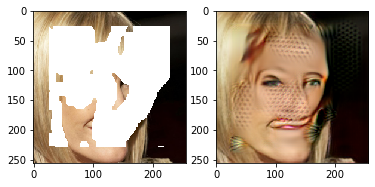

In [16]:
rdint = randint(1, 200)
input_img = f"demo_tests/{rdint}.jpg"
input_mask = f"demo_tests/{rdint}.png"
input = [read_image(input_img), read_mask(input_mask)]
predicted_img = gmcnn_gan_model.predict(input)
masked_img = img_masker(input_img, input_mask)
show_images(masked_img, predicted_img[0])

In [15]:
psnr_list = []
for i in range(1, 201):
    input_img = f"demo_tests/{i}.jpg"
    input_mask = f"demo_tests/{i}.png"
    input = [read_image(input_img), read_mask(input_mask)]
    predicted_img = gmcnn_gan_model.predict(input)
    psnr_value = psnr(read_image(input_img)[0], predicted_img[0])
    psnr_list.append(psnr_value)
average_psnr = sum(psnr_list) / len(psnr_list)
print(f"Average PSNR = {average_psnr}")

Average PSNR = 27.471800551993944
